<a href="https://colab.research.google.com/github/Nits11/GMS_6803/blob/master/build_model_rftuned_oversample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sklearn
import scipy
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
# hide annoying convergence warning for logistic regression
# due to one hot encoding
import warnings
warnings.simplefilter('ignore')

### Load train data

In [4]:
X_train = pd.read_csv("data/x_train.csv")
y_train = pd.read_csv("data/y_train.csv")

### Perform Oversampling on Train data

Possilbe sources of information
1. https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

2. https://ieeexplore.ieee.org/document/8492368

Oversample minority class to have 80% of the number of observations as the majority class
Safeguard to ensure that model would still be able to detect a signal in the minority class and generalize to new data

Downside is that oversampling is also performed on the heldout set in cv. This effect is seen in the differences in `test_balanced_accuracy` when comparing models

In [5]:
oversample = RandomOverSampler(sampling_strategy=0.8, random_state=42)
X_train_oversample, y_train_oversample = oversample.fit_resample(
    X_train, y_train)

In [6]:
print("Distribution of train set before and after oversampling")
print("X_train:", X_train.shape)
print("X_train_oversample:", X_train_oversample.shape)
print("y_train:", y_train.shape)
print("y_train_oversample:", y_train_oversample.shape)

Distribution of train set before and after oversampling
X_train: (745, 48)
X_train_oversample: (1110, 48)
y_train: (745, 1)
y_train_oversample: (1110,)


In [7]:
print("Distribution of Diabetes in Train Set")
y_train.value_counts()

Distribution of Diabetes in Train Set


diabetes
1           617
0           128
dtype: int64

In [9]:
print("Distribution of Diabetes in Oversampled Train Set")
pd.DataFrame(y_train_oversample).value_counts()

Distribution of Diabetes in Oversampled Train Set


1    617
0    493
dtype: int64

### Create CV splits and Specify Model Metrics

Possible source of information as to why CV is done
1. https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [10]:
metrics = ['precision', 'recall', 'f1', 'roc_auc', 'balanced_accuracy']

scoring_metrics = ['test_' + x for x in metrics]

# needs to be outside function to ensure every model uses the same cv splits for measuring model performance
kfold = model_selection.StratifiedKFold(n_splits=5)

### Create function that accepts a given model and returns the metrics from Cross-Validation

The function fits a model to k-1 subsets of each resample and evaluates on the kth subset from each resample. thus for 5-fold CV the model is trained on 4 folds and tested on the fifth fold. This process is repeated 4 more times and the average of each metric across the 5 folds is calculated.

In [11]:
# create function to return cv results for a given model
def get_model_metrics(model, train_features, train_labels, model_name, over_sampling):

    cv_results = model_selection.cross_validate(
        model, train_features, train_labels, cv=kfold, scoring=metrics)

    df = pd.DataFrame(
        columns=['Algorithm', 'Over Sampling', 'Metric', 'Value'])

    for metric in scoring_metrics:
        score_value = round(cv_results[metric].mean(), 2)
        df = df.append({'Algorithm': model_name, 'Over Sampling': over_sampling, 'Metric': metric, 'Value': score_value},
                       ignore_index=True)

    return(df)


#### Test different models


In [12]:
log_reg_model = get_model_metrics(LogisticRegression(random_state=42), X_train, y_train, 'logistic regression', "No")

oversample_log_reg_model = get_model_metrics(LogisticRegression(random_state=42), X_train_oversample, y_train_oversample, 'logistic regression', "Yes")

In [13]:
svm_model = get_model_metrics(
    SVC(kernel='linear', random_state=42), X_train, y_train, "svm (linear kernel)", "No")

oversample_svm_model = get_model_metrics(SVC(
    kernel='linear', random_state=42), X_train_oversample, y_train_oversample, "svm (linear kernel)", "Yes")

In [14]:
xgb_model = get_model_metrics(
    XGBClassifier(random_state=42), X_train, y_train, "xgboost", "No")
oversample_xgb_model = get_model_metrics(
    XGBClassifier(random_state=42), X_train_oversample, y_train_oversample, "xgboost", "Yes")

In [15]:
rf_model = get_model_metrics(
    RandomForestClassifier(random_state=42), X_train, y_train, "random forest", "No")
oversample_rf_model = get_model_metrics(RandomForestClassifier(random_state=42), X_train_oversample, y_train_oversample, "random forest", "Yes")

#### Hyperparameters Fine-tuning
Fine-tuning of any ML model involves an iterative searching for finding a set of hyper-parameters which can optimize the model performance during training/validation process. This search can be a Randomized search  for a given number of iterations in the provided hyper-parameter search space for generating best model performance (on provided scoring criteria). 

Alternatively, a more exhaustive search can be performed for all combinations of the provided grid of parameters aimed to optimize the model performance. 


Selection of parameters for fine-tuning is model- specific and for random forest involves multiple features related to number of decisions trees and considered features during node- splitting. The whole process is a try and learn exercise and not necessarily results in model with improved performance from default.



#### Hyperparameter tuning of random forest
Hyper parameter tuning for Random forest was explored using ‘RandomizedSearchCV’ function for 50 iterations available in Scikit-Learn library with cross-validation on training data for the following hyperparameters: 
*	n_estimators = number of trees to build before taking maximum/average prediction voting, higher number , slow tree convergence
*	max_features = maximum number of features considered for splitting a node
*	max_depth = maximum number of levels in each decision tree
*	min_samples_split = minimum number of data points placed in a node before splitting 
*	min_samples_leaf = minimum number of data points allowed in a leaf node
*	bootstrap = method for sampling data points, with or without replacement
*	criterion = Scoring method for estimating the quality of node splitting ,  commonly used are ‘gini’ (uses the Gini impurity) or “entropy”(uses information gain Entropy)

Performance of the Tuned model was compared with default model  and is enumerated in the table.

In [16]:
print("Default values for random forest")
pprint(RandomForestClassifier().get_params())

Default values for random forest
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Initiate the random grid search

In [17]:
random_grid = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'min_samples_split': [ 5, 10],
               'min_samples_leaf': [4, 6, 10],
               'bootstrap': [True, False],
               'criterion' : ['gini', 'entropy']
               }

# use the random grid to search for best hyperparameters
# random search of parameters, using 5 fold cross validation
# search across 50 different combinations
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=random_grid,
                               scoring='balanced_accuracy', n_iter=100, cv=kfold, random_state=42, n_jobs=-1)

Perform the randomized search for combinations of given grid parameters and for 100 iterations

In [20]:
# Fit the random search model
rf_random.fit(X_train, y_train)



Balanced Accuracy was the scoring metric used in the grid search


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [21]:
# show the best hypermaters
print("Balanced Accuracy was the scoring metric used in the grid search")
rf_random.best_params_

Balanced Accuracy was the scoring metric used in the grid search


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

Use the best hypermaters returned from the Randomised grid search on the train data

In [28]:
rf_tune = RandomForestClassifier(random_state=42, bootstrap=True, criterion= 'gini', max_depth=80, max_features='sqrt',
                                 min_samples_leaf=4, min_samples_split=10, n_estimators=400)

Perform Randomised grid search on the oversampled train set

In [22]:
rf_random.fit(X_train_oversample, y_train_oversample)
pprint(rf_random.best_params_)

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1000}


In [29]:
rf_tune.fit(X_train_oversample, y_train_oversample)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Use the best hypermaters returned from the Randomised grid search on the oversampled train data

In [30]:
oversample_rf_tune = RandomForestClassifier(random_state=42, bootstrap=True, criterion= 'entropy', max_depth=80, max_features='auto',
                                 min_samples_leaf=4, min_samples_split=2, n_estimators=1200)

In [34]:
rf_model_tuned = get_model_metrics(
    rf_tune, X_train, y_train, "random forest (tuned)", "No")

oversample_rf_model_tuned = get_model_metrics(
    oversample_rf_tune, X_train_oversample, y_train_oversample, "random forest (tuned)", "Yes")

### Compare the cross validation metrics across all models 
This table compares the evaluation metrics on the heldout fold from cross-validation for multiple models. The table is sorted in descending order of `test_balanced_accuracy`.

If we care more about detecting cases than controls use F1. If we care about both use balanced accuracy.

Possible sources of info for which metrics to choose:
1. https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall 

2. http://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html#:~:text=Balanced%20accuracy%20is%20calculated%20as,of%20examples%20in%20each%20class.

In [35]:
compare_models = (pd.concat([log_reg_model, oversample_log_reg_model, 
                            xgb_model, oversample_xgb_model,
                            svm_model, oversample_svm_model,
                            rf_model, oversample_rf_model,
                            rf_model_tuned, oversample_rf_model_tuned])
                    .pivot(index=['Algorithm','Over Sampling'], columns='Metric', values='Value')
                    .reset_index()
                    .sort_values(by='test_balanced_accuracy', ascending=False)
)

compare_models.rename_axis(None, axis=1)

,Algorithm,Over Sampling,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc
3,random forest,Yes,0.96,0.96,0.99,0.92,1.00
9,xgboost,Yes,0.92,0.92,0.95,0.90,0.96
5,random forest (tuned),Yes,0.90,0.91,0.92,0.90,0.97
1,logistic regression,Yes,0.86,0.87,0.89,0.85,0.92
7,svm (linear kernel),Yes,0.85,0.86,0.89,0.84,0.92
4,random forest (tuned),No,0.77,0.94,0.92,0.96,0.91
6,svm (linear kernel),No,0.77,0.92,0.92,0.91,0.90
2,random forest,No,0.76,0.93,0.91,0.95,0.90
8,xgboost,No,0.76,0.93,0.92,0.94,0.90
0,logistic regression,No,0.74,0.92,0.91,0.93,0.90


### Load the Test Set

In [37]:
# load the test data
X_test = pd.read_csv("data/x_test.csv")
y_test = pd.read_csv("data/y_test.csv")

print(X_test.shape)
print(y_test.shape)

(185, 48)
(185, 1)


### Choose the best model

__This was my opinion of the results. Can you all specificy what you think will be the best model based on your perception of the metrics and prediction goals. I'm focused on being able to predict both classes properly. Some people may be focused on predicting only the positive class correctly__.

From the metrics table the two random forest models fit to the oversampled train set had the highest balanced accuracy but the ROCAUC scores for both of these models was 1. These models may be overfitting on the traing data. The xgboost model performance on the oversampled train data had a balanced accuracy score of 0.95. Additionally, all other metrics for this model was above 0.95 except for the recall. This model may have also been overfitted to the training data but to a lesser degree than the random forest models. Thus, xgboost might be able to generalize better to new data when compared to the random forest model. xgboost will be used as the final model based on these finding.

 

#### Fit the best model to the full oversampled train data then predict using the test data

In [44]:
best_model = RandomForestClassifier(random_state=42, bootstrap=True, criterion= 'entropy', max_depth=80, max_features='auto',
                                 min_samples_leaf=4, min_samples_split=2, n_estimators=1200)

model_fit_on_train = best_model.fit(X_train_oversample, y_train_oversample)

y_pred_class = model_fit_on_train.predict(X_test)

In [45]:
from sklearn import metrics
print("Performance on test set")
print("F1:", metrics.f1_score(y_test, y_pred_class).round(2))
print("Precision:", metrics.precision_score(y_test, y_pred_class).round(2))
print("Recall:", metrics.recall_score(y_test, y_pred_class).round(2))
print("ROC-AUC:", metrics.roc_auc_score(y_test, y_pred_class).round(2))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(
    y_test, y_pred_class).round(2))

Performance on test set
F1: 0.94
Precision: 0.93
Recall: 0.95
ROC-AUC: 0.8
Balanced Accuracy: 0.8


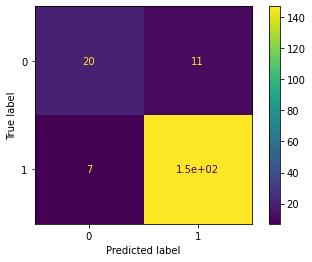

In [39]:
plot_confusion_matrix(model_fit_on_train, X_test, y_test)

Text(0.5, 0, 'Importance')

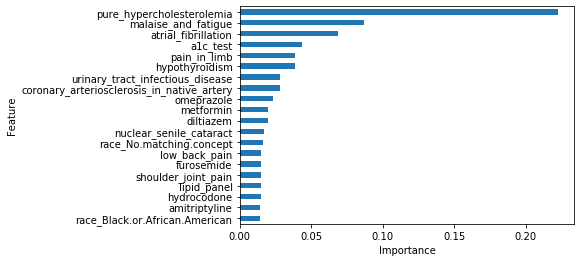

In [ ]:
feat_importances = pd.Series(
    best_model.feature_importances_, index=X_train_oversample.columns)
feature_plot = feat_importances.nlargest(20).sort_values().plot(kind='barh')
feature_plot.set_ylabel('Feature', size=10)
feature_plot.set_xlabel('Importance', size=10)